<a href="https://colab.research.google.com/github/KitHub-NK/VAE/blob/main/toyVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import packages**
Connect to T4 server which has higher GPU and import packages

In [4]:
# train autoencoder for classification with with compression in the bottleneck layer
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras import Model
from keras.layers import Input, Dense, Lambda

In [5]:
# Ensure if the GPU is enabled
tf.test.gpu_device_name()

'/device:GPU:0'

# Data Prep
Three different synthetic datasets

In [6]:
#Data1
from sklearn.datasets import make_blobs
data1, y1 = make_blobs(n_samples=1000,
                  centers=2, n_features=2,cluster_std=0.5,
                  random_state=0)

In [7]:
#Data2
cov   = [[1,.9],[.9,1]]
data1x = np.random.multivariate_normal([-1.1,.1],cov,500)
data2x = np.random.multivariate_normal([1.1,-.1],cov,500)
data2  = np.concatenate((data1x,data2x),axis=0)
y2 = np.repeat([0,1], 500)

In [8]:
#Data3
from sklearn.datasets import make_gaussian_quantiles
# Construct dataset
data3, y3 = make_gaussian_quantiles(cov=3.,
                                 n_samples=10000, n_features=2,
                                 n_classes=2, random_state=1)

## Choose a dataset to continue

In [9]:
data = data1
y = y1

## Visualize the data

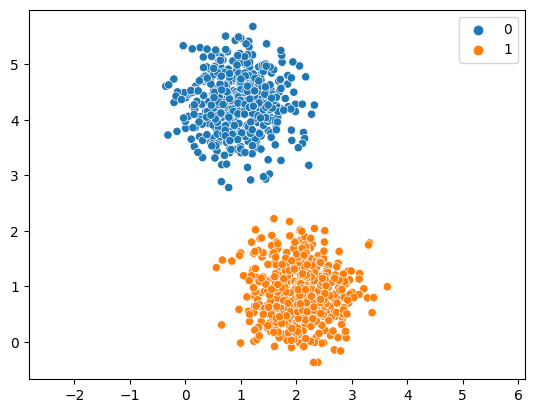

In [10]:
sns.scatterplot(x=data[:,0], y=data[:,1], hue = y)
plt.axis('equal')
plt.show()

## Training-testing partition


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

 ## Scale the data by training parameters

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Prep

In [14]:
# Define VAE architecture
def create_VAE(input_dim, latent_dim):
    # Encoder Model
    inputs  = Input(shape=(input_dim,), name='Input')
    x       = Dense(20, activation = 'relu')(inputs)
    x       = Dense(20, activation = 'relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # VAE sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Sampling layer
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    lat_input = Input(shape=(latent_dim,))
    x = Dense(20, activation='relu')(lat_input)
    x = Dense(20, activation='relu')(x)
    decoded = Dense(input_dim, activation='linear')(x)

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(lat_input, decoded, name="decoder")

    # VAE
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    # VAE loss
    xent_loss = input_dim * tf.keras.losses.mean_squared_error(inputs, outputs)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)

    return vae, encoder, decoder

In [15]:
# Create Autoencoder
vae,enc,dec = create_VAE(input_dim=2,latent_dim=1)

## Compile the model

In [16]:
# Compile the VAE model, without a loss definition as you already did above
vae.compile(optimizer='adam')

## Plot model architecture

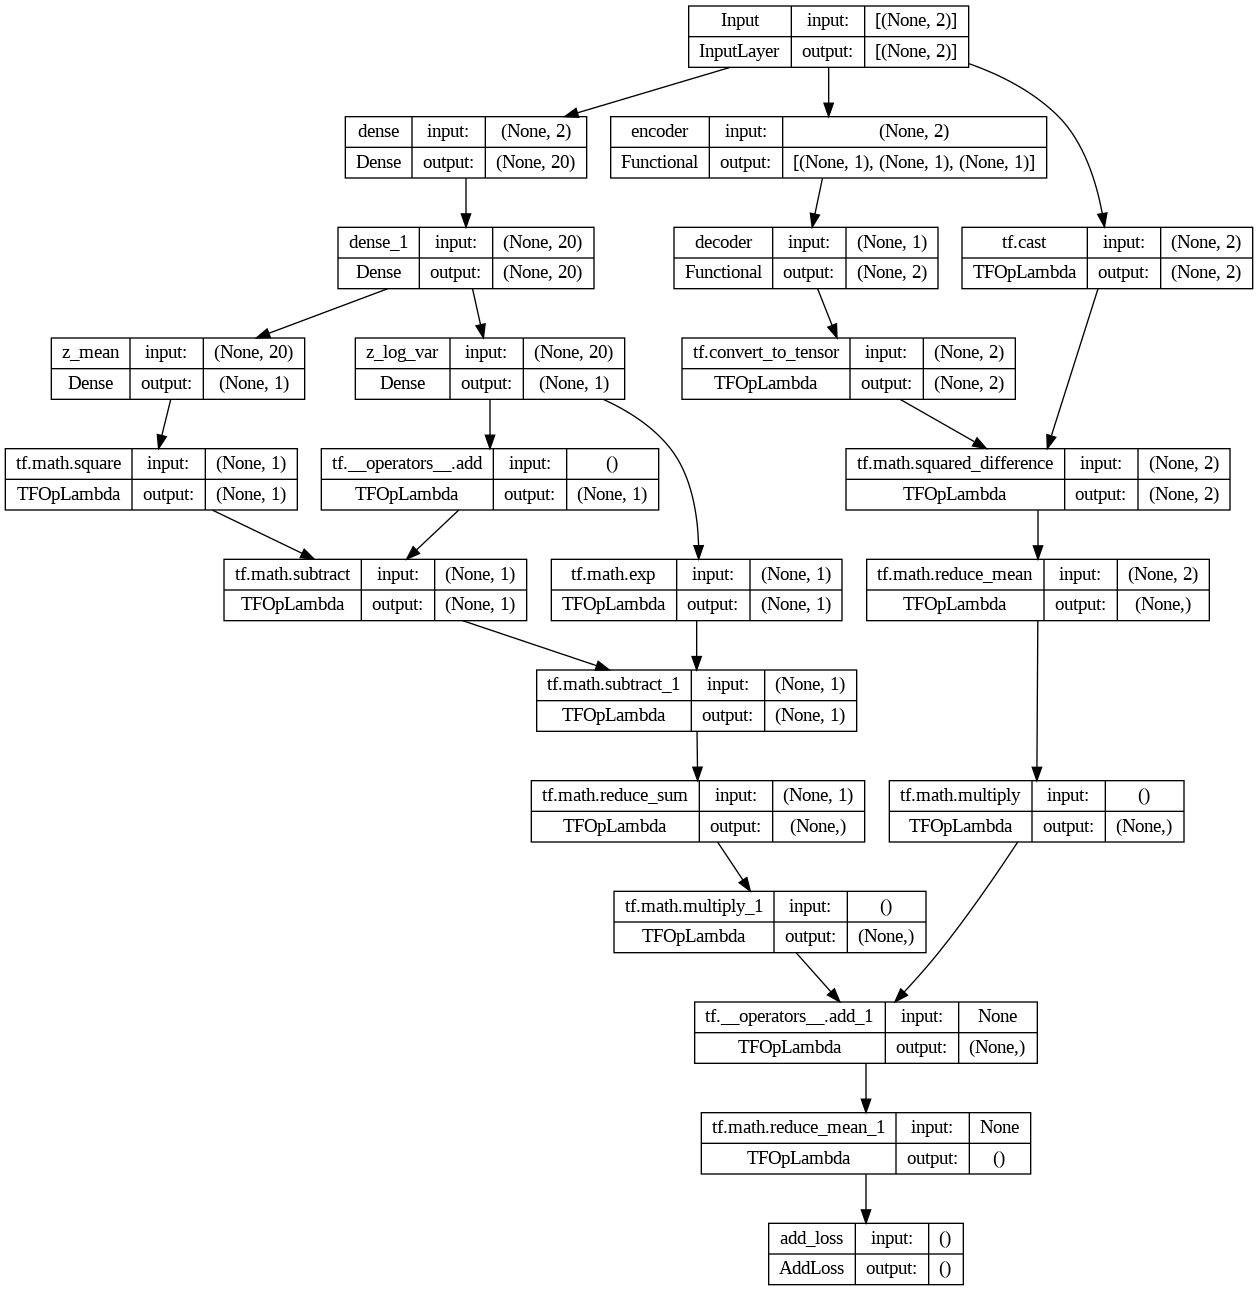

In [17]:
plot_model(vae, show_shapes= True, show_layer_names=True)

## Train the VAE

In [18]:
epoch = 100
batch_size = 32
history = vae.fit(X_train, X_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, X_test))

Epoch 1/100
25/25 [==============================] - 6s 37ms/step - loss: 2.0162 - val_loss: 1.7167
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 1.9747 - val_loss: 1.7212
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 1.9343 - val_loss: 1.7313
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 1.8736 - val_loss: 1.5128
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 1.7148 - val_loss: 1.4139
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 1.5236 - val_loss: 1.2561
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4434 - val_loss: 1.2645
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 1.3754 - val_loss: 1.2029
Epoch 9/100
25/25 [==============================] - 1s 36ms/step - loss: 1.3031 - val_loss: 1.2211
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 1.3629 - val_loss: 1.1888
Epoch 1

## Plot Model Evolution


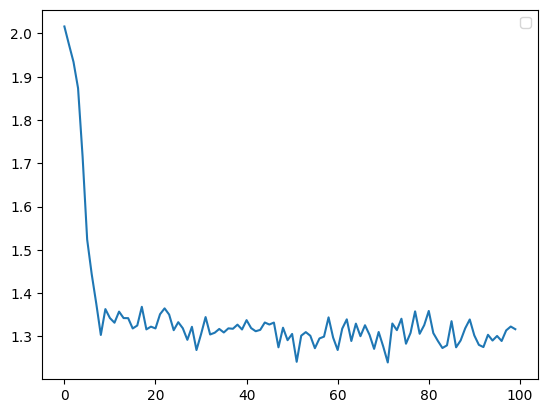

In [19]:
# plot loss
plt.plot(history.history['loss'])
plt.legend()
plt.show()

# Generate Decoded Samples

This generates a new set of samples and allows us to see how model generalized the training data

In [20]:
reconstructed_data = vae.predict(X_test)

7/7 [==============================] - 0s 2ms/step


Extract the latents too

In [21]:
latent_representation = reconstructed_data[:,0]  # Extracting the mean of the latent space

# Evaluate the machine performance

In [25]:
# Evaluate the VAE on test data
loss = vae.evaluate(X_test, X_test)
print(f'Test loss VAE: {loss}')

7/7 [==============================] - 0s 51ms/step - loss: 1.3116
Test loss VAE: 1.3115875720977783


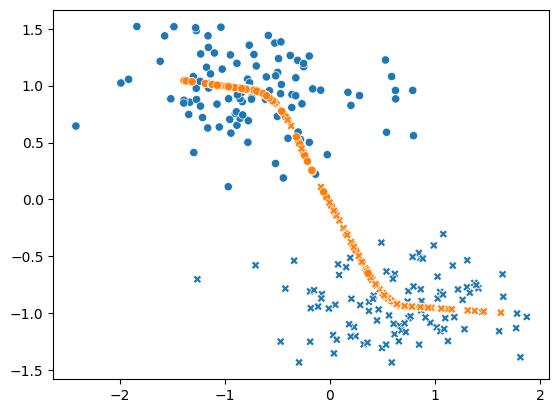

In [26]:
# Look at predictions
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], style = y_test)
sns.scatterplot(x=reconstructed_data[:,0], y=reconstructed_data[:,1], style = y_test)
plt.legend([],[], frameon=False)